In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import batman
from scipy import optimize

In [34]:
np.random.seed(100)

In [35]:
#System
#http://exoplanets.org/detail/Kepler-19_b
#Semi-Major Axis[au]	0.0846 ± 0.00141
#Orbital Period[day]	9.2869944 ± 8.8×10-6
#Orbit Inclination[deg]	89.94 +0.15/-0.35
#Planetary Radius[rjupiter]	0.1971 ± 0.0043
#Radius of Star[rsun]	0.850 ± 0.018
#Argument of Periastron[deg]	90

#Star
#Teff[k]	5541 ± 60
#[Fe/H]	-0.130 ± 0.06
#log10(g)	4.59 ± 0.1
#Using - https://astroutils.astronomy.osu.edu/exofast/limbdark.shtml
#Kepler bandpass
#Quadratic coefficients:
#   0.43135341      0.24553668


#TESS has a cadence of 2 minutes
#0.2 of a day has 144 measurements

In [36]:
def radius_in_stellar_radii(R_planet, R_star):
    """
    Convert planetary radius (R_Jupiter) in stellar radii.
    
    Parameters
    ----------
    R_planet : float
        Planetary radius in R_Jupiter.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    R_planet_stellar_radii : float 
        Planetary radius in stellar radii.

    """
    # 1 R_Jupiter = 0.102763 R_sun

    R_planet_stellar_radii = R_planet * 0.102763 / R_star

    return R_planet_stellar_radii

In [37]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star #Check this

    return a_stellar_radii

In [48]:
true_R_star = 0.850 #R_sun
true_R_planet = 0.1971 #R_J
true_semi_major_axis = 0.0846 #AU 


params = batman.TransitParams()
params.t0 = 0.                                          #time of inferior conjunction
params.per = 9.2869944                                        #orbital period (days)
params.rp = radius_in_stellar_radii(true_R_planet, true_R_star)                #planet radius (in units of stellar radii)
params.a = semi_major_axis_in_stellar_radii(true_semi_major_axis, true_R_star) #semi-major axis (in units of stellar radii))
params.inc = 89.94                                      #orbital inclination (in degrees)
params.ecc = 0.0                                         #eccentricity
params.w = 90.                                          #longitude of periastron (in degrees)
params.limb_dark = "quadratic"                          #limb darkening model
params.u = [0.43135341, 0.24553668]                             #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.1, 0.1, 144)                      #times at which to calculate light curve
m = batman.TransitModel(params, t)                      #initializes model
flux = m.light_curve(params)
true_flux = m.light_curve(params)

In [49]:
#Add noise to the signal
sigma = 0.00001
yerrs = np.random.normal(loc=0., scale=sigma, size=len(flux))
true_flux += yerrs

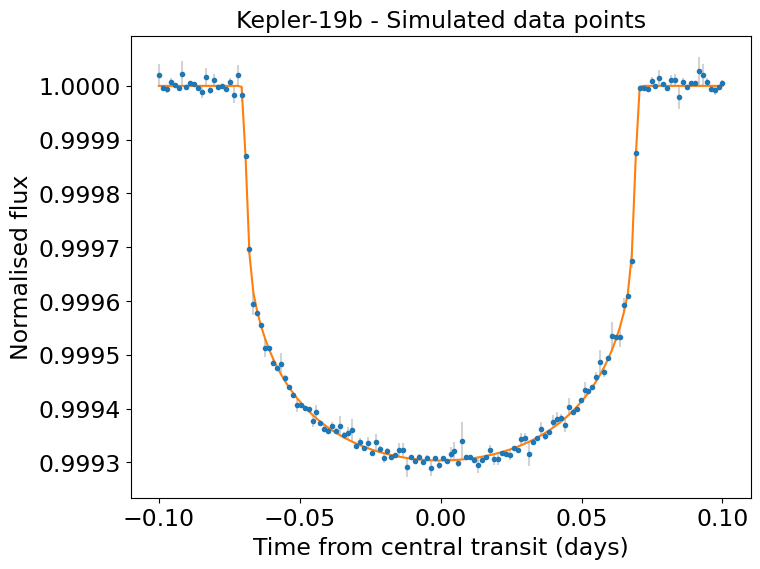

In [52]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title("Kepler-19b - Simulated data points", size=17)
plt.errorbar(t, true_flux, yerr=yerrs, fmt='.', ecolor='LightGrey', label="Simulated noise")
plt.plot(t, flux, label="Model")
plt.xlabel("Time from central transit (days)", size=17)
plt.ylabel("Normalised flux", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
plt.show()

In [41]:

guess_params = batman.TransitParams()
guess_params.t0 = params.t0
guess_params.per = params.per



guess_params.ecc = params.ecc
guess_params.w = params.w
guess_params.limb_dark = "quadratic"
guess_params.u = params.u

In [42]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    orbital_inclination, R_planet, semi_major_axis = prior_params

    
    guess_params.rp = radius_in_stellar_radii(R_planet, true_R_star)
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis_in_stellar_radii(semi_major_axis, true_R_star)

    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)
        
    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2)
    L2 = -0.5 * np.log(2 * np.pi * yerrs**2) 
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(prior_params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    orbital_inclination, R_planet, semi_major_axis = prior_params

    P = 0.0
    if (orbital_inclination > 90) or (orbital_inclination < 45):
        P += -np.inf
        return -np.inf
    
    if (R_planet < 0):
        P += -np.inf
        return P

    if (semi_major_axis < 0):
        P += -np.inf
        return P
    

    return P

def log_prob(prior_params, true_flux, yerrs):
    lp = log_prior(prior_params)
    # if not np.isfinite(lp):
    #     return -np.inf

    return -(log_likelihood(prior_params, true_flux, yerrs)) + -1*(lp)

In [43]:
#orbital_inclination, R_planet, semi_major_axis
guess = [89, 0.18, 0.08]
bnds = ((45, 90), (0, 0.3), (0, 0.2)) #Boundaries

likelihood_model = optimize.minimize(log_prob, guess, args=(true_flux, yerrs), bounds=bnds)
model_orbital_inclination, model_R_planet, model_semi_major_axis = (likelihood_model['x'])
print(likelihood_model)

      fun: -1548.2472928507216
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   -4.06642158, -3965.60942799,  1190.45028049])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 624
      nit: 107
     njev: 156
   status: 0
  success: True
        x: array([8.99042857e+01, 1.97108266e-01, 8.45553304e-02])


In [44]:
model_params = batman.TransitParams()
model_params.t0 = params.t0
model_params.per = params.per
model_params.rp = radius_in_stellar_radii(model_R_planet, true_R_star)
model_params.a = semi_major_axis_in_stellar_radii(model_semi_major_axis, true_R_star)
model_params.inc = model_orbital_inclination
model_params.ecc = params.ecc
model_params.w = params.w
model_params.limb_dark = "quadratic"
model_params.u = params.u


model_m = batman.TransitModel(model_params, t)                      #initializes model
model_flux = model_m.light_curve(model_params)

In [45]:
residual = model_flux - true_flux

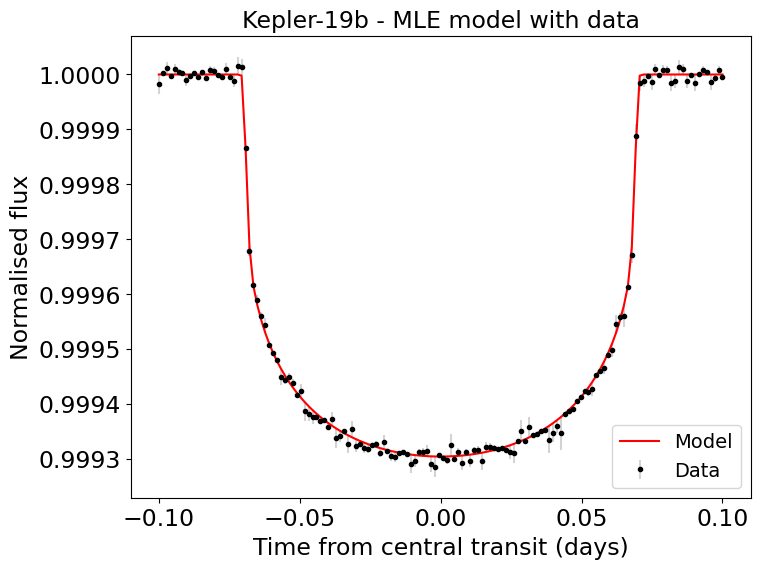

In [46]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title("Kepler-19b - MLE model with data", size=17)
plt.errorbar(t, true_flux, yerr=yerrs, fmt='.', ecolor='LightGrey', color="black", label="Data")
plt.plot(t, model_flux, label="Model", color="red")
plt.xlabel("Time from central transit (days)", size=17)
plt.ylabel("Normalised flux", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
ax.legend(prop={'size': 14}, loc="lower right")

plt.show()

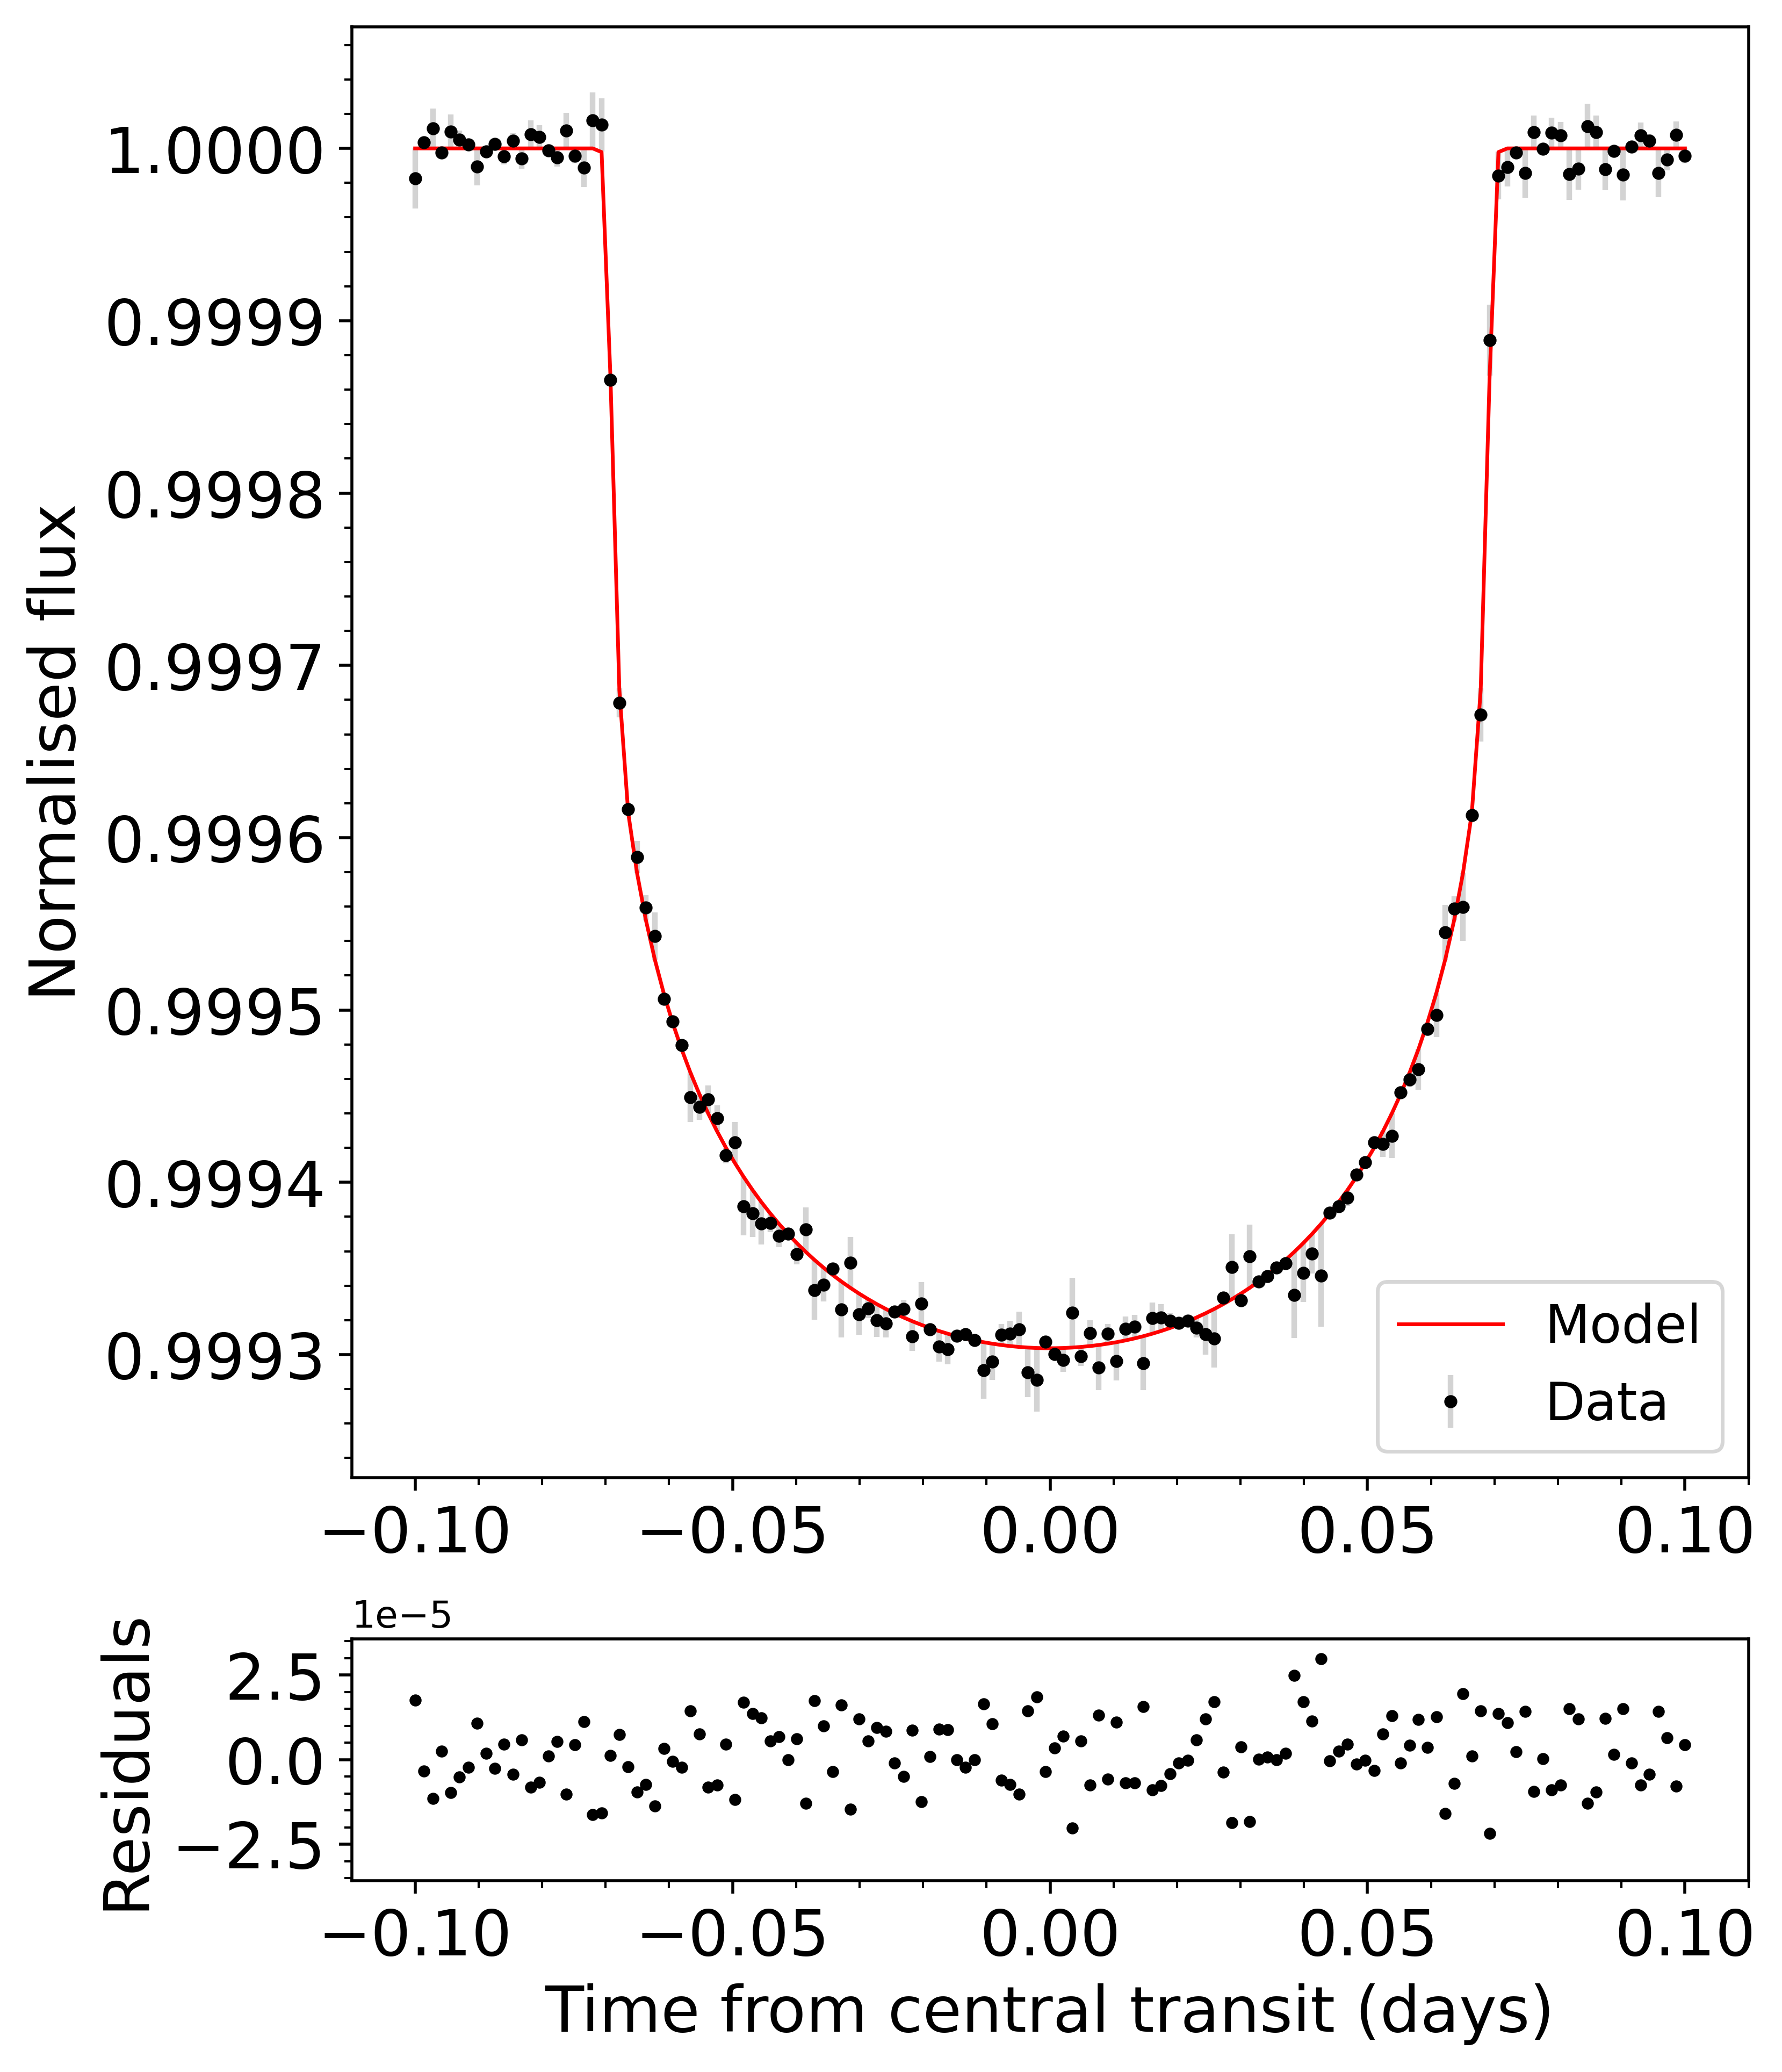

In [47]:
#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(8, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t, true_flux, yerr=yerrs, fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data")
ax.plot(t, model_flux, color='red',label="Model", lw=1)

ax.set(ylabel="Normalised flux")
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)

ax.legend(prop={'size': 14}, loc="lower right")

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Bottom panel
ax_res.scatter(t, residual, color='black', s=5)
ax_res.set_ylim((-max(abs(residual))*1.2, max(abs(residual)*1.2)))
# ax_res.plot([min(t), max(t)], [0, 0], color='red', lw=1)

ax_res.set(xlabel="Time from central transit (days)", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()